<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/MI_FGSM_Attack_for_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [1]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Image Visualization</b>

In [3]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

#### <b>Load Pre-trained Classification Model</b>

In [4]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ETrdVDcb8g1KpyZ6qjSprGMB19bCkRQt88_Sdr_VFXn3UQ?download=1 -O ResNet20_CIFAR10.pt
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYU8SZo5MzxHlzIjlu4We9QBHpk1LO0I3PgTkv2Gurqcow?download=1 -O AlexNet_CIFAR10.pt

--2021-04-30 23:46:14--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ETrdVDcb8g1KpyZ6qjSprGMB19bCkRQt88_Sdr_VFXn3UQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CSED703G_ResNet20_CIFAR10.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVHJkVkRjYjhnMUtweVo2cWpTcHJHTUIxOWJDa1JRdDg4X1Nkcl9WRlhuM1VRP3J0aW1lPVhXU2hKRElNMlVn [following]
--2021-04-30 23:46:15--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CSED703G_ResNet20_CIFAR10.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVHJkVkRjYjh

In [5]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


# ResNet을 위한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes // 4, planes // 4), "constant", 0))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        # 16개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [6]:
class LocalResponseNorm(nn.Module):
    def __init__(self, size, alpha = 1e-4, beta = 0.75, k = 1.0):
        super(LocalResponseNorm, self).__init__()
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def forward(self, input):
        return F.local_response_norm(input, self.size, self.alpha, self.beta, self.k)


class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # 여기에서 (3 x 32 x 32)
            # 입력 채널: 3, 출력 채널: 96 (커널 96개)
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (96 x 32 x 32)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (96 x 15 x 15)
            # 입력 채널: 96, 출력 채널: 256 (커널 256개)
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (256 x 15 x 15)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (256 x 7 x 7)
            # 입력 채널: 256, 출력 채널: 384 (커널 384개)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 7 x 7)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 7 x 7)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 7 x 7)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (384 x 3 x 3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(384 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
            nn.Dropout(),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [8]:
model = ResNet20()
checkpoint = torch.load('./ResNet20_CIFAR10.pt')
model.load_state_dict(checkpoint['net'])
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    model
)
model = model.to(device)

In [9]:
black_box_model = AlexNet()
checkpoint = torch.load('./AlexNet_CIFAR10.pt')
black_box_model.load_state_dict(checkpoint['net'])
black_box_model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    black_box_model
)
black_box_model = black_box_model.to(device)

#### <b>Load Test Dataset</b>

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform_test = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified


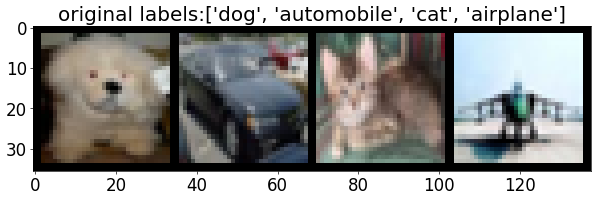

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #2: automobile (1)
Image #3: cat (3)
Image #4: airplane (0)


In [11]:
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(test_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([class_names[x] for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, label in enumerate(classes[:4]):
    print(f'Image #{i + 1}: {class_names[label]} ({label})')

#### <b>Test Phase</b>

* White-box model

[Prediction Result Examples]


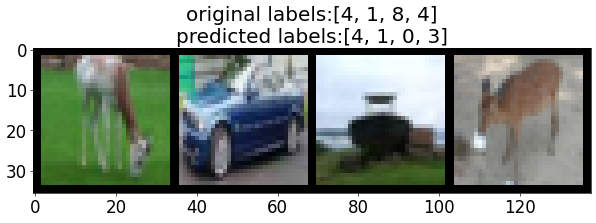

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: automobile (1)
Image #1: ship (8)
Image #1: deer (4)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: automobile (1)
Image #1: airplane (0)
Image #1: cat (3)


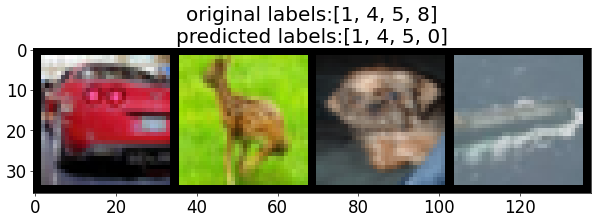

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: deer (4)
Image #1: dog (5)
Image #1: ship (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: deer (4)
Image #1: dog (5)
Image #1: airplane (0)
[Validation] Loss: 0.0092 Accuracy: 85.6300% Time elapsed: 1.9890s (total 10000 images)


In [12]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

* Black-box model

[Prediction Result Examples]


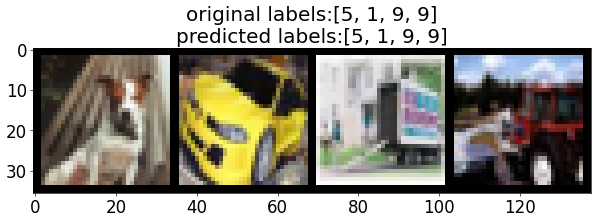

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: automobile (1)
Image #1: truck (9)
Image #1: truck (9)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: automobile (1)
Image #1: truck (9)
Image #1: truck (9)


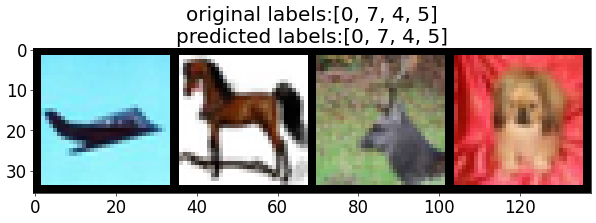

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #1: horse (7)
Image #1: deer (4)
Image #1: dog (5)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #1: horse (7)
Image #1: deer (4)
Image #1: dog (5)
[Validation] Loss: 0.0088 Accuracy: 86.1400% Time elapsed: 2.3873s (total 10000 images)


In [13]:
import time

criterion = nn.CrossEntropyLoss()
black_box_model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = black_box_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [14]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

In [15]:
# FGSM 공격 함수
def fgsm_attack(model, images, labels, eps):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
    perturbation = torch.zeros_like(images).to(device)
    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss()

    # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
    perturbation.requires_grad = True

    outputs = model(images + perturbation) # 모델의 판단 결과 확인

    # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
    model.zero_grad()
    cost = attack_loss(outputs, labels).to(device)
    cost.backward()

    # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
    diff = perturbation.grad.sign()
    # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
    perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, perturbation

In [16]:
# PGD 공격 함수
def pgd_attack(model, images, labels, targeted, eps, alpha, iters):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
    # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
    perturbation = torch.empty_like(images).uniform_(-eps, eps).to(device)
    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss()

    for i in range(iters):
        # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
        perturbation.requires_grad = True

        # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
        current = torch.clamp(images + perturbation, min=0, max=1)
        outputs = model(current) # 모델의 판단 결과 확인

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
        model.zero_grad()
        cost = attack_loss(outputs, labels).to(device)
        cost.backward()

        if targeted: # 타겟이 있는(targeted) 공격인 경우
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
            diff = -alpha * perturbation.grad.sign()
        else:
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = alpha * perturbation.grad.sign()
        # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, perturbation

In [17]:
# MI-FGSM 공격 함수
def mi_fgsm_attack(model, images, labels, targeted, eps, alpha, iters, decay):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
    # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
    perturbation = torch.empty_like(images).uniform_(-eps, eps).to(device)
    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss()

    for i in range(iters):
        # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
        perturbation.requires_grad = True

        # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
        current = torch.clamp(images + perturbation, min=0, max=1)
        outputs = model(current) # 모델의 판단 결과 확인

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
        model.zero_grad()
        cost = attack_loss(outputs, labels).to(device)
        cost.backward()
        
        grad = perturbation.grad
        grad_norm = torch.norm(grad.view(inputs.shape[0], -1), p=1, dim=1)
        grad = grad / grad_norm.view(-1, 1, 1, 1)
        if i != 0:
            grad = momentum * decay + grad
        momentum = grad

        if targeted: # 타겟이 있는(targeted) 공격인 경우
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
            diff = -alpha * grad.sign()
        else:
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = alpha * grad.sign()
        # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, perturbation

In [25]:
import time

eps = 16/255
alpha = 2/255
iters = 30

criterion = nn.CrossEntropyLoss()
model.eval().to(device)
black_box_model.eval().to(device)

Sequential(
  (0): Normalize()
  (1): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): LocalResponseNorm()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): LocalResponseNorm()
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Linear(in_fe

#### <b>FGSM Attack</b>

* White-box attack

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


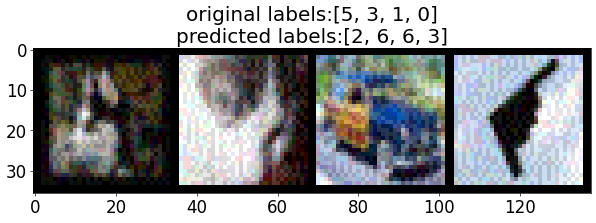

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: cat (3)
Image #1: automobile (1)
Image #1: airplane (0)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: frog (6)
Image #1: frog (6)
Image #1: cat (3)


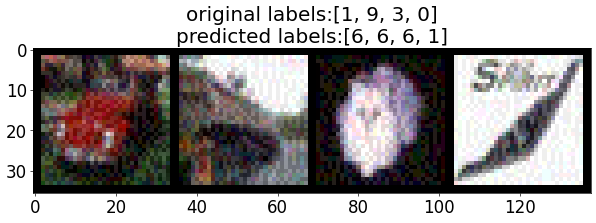

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: truck (9)
Image #1: cat (3)
Image #1: airplane (0)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: frog (6)
Image #1: frog (6)
Image #1: automobile (1)
[Step #0] Loss: 0.1351 Accuracy: 6.2500% Time elapsed: 0.4378s (total 64 images)
[Step #10] Loss: 0.1364 Accuracy: 6.2500% Time elapsed: 0.7472s (total 704 images)
[Step #20] Loss: 0.1371 Accuracy: 5.7292% Time elapsed: 1.0010s (total 1344 images)
[Step #30] Loss: 0.1372 Accuracy: 5.7964% Time elapsed: 1.2344s (total 1984 images)
[Step #40] Loss: 0.1375 Accuracy: 5.4497% Time elapsed: 1.4703s (total 2624 images)
[Step #50] Loss: 0.1371 Accuracy: 5.7292% Time elapsed: 1.7041s (total 3264 images)
[Step #60] Loss: 0.1384 Accuracy: 5.4559% Time elapsed: 1.9463s (total 3904 images)
[Step #70] Loss: 0.1390 Accuracy: 5.5678% Time elapsed: 2.1811s (total 4544 images)
[Step #80] Loss: 0.1389 Accuracy: 5.5941% Time elapsed: 2.4153s (total 5184 ima

In [26]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted, perturbation = fgsm_attack(model, inputs, labels, eps)  # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

* Black-box attack

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


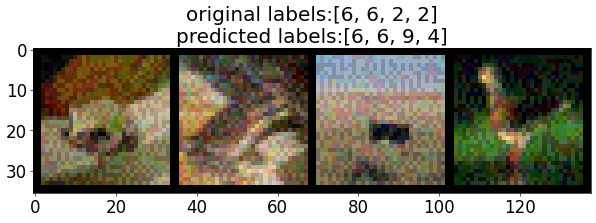

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: frog (6)
Image #1: bird (2)
Image #1: bird (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: frog (6)
Image #1: truck (9)
Image #1: deer (4)


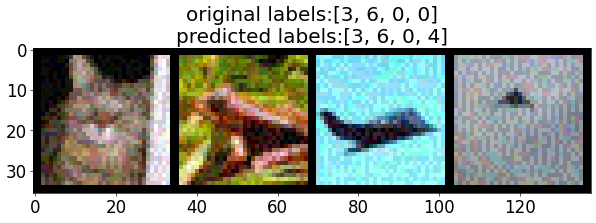

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: frog (6)
Image #1: airplane (0)
Image #1: airplane (0)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: frog (6)
Image #1: airplane (0)
Image #1: deer (4)
[Step #0] Loss: 0.0366 Accuracy: 53.1250% Time elapsed: 0.4168s (total 64 images)
[Step #10] Loss: 0.0412 Accuracy: 50.0000% Time elapsed: 0.7262s (total 704 images)
[Step #20] Loss: 0.0409 Accuracy: 50.5208% Time elapsed: 1.0220s (total 1344 images)
[Step #30] Loss: 0.0417 Accuracy: 50.1512% Time elapsed: 1.3188s (total 1984 images)
[Step #40] Loss: 0.0412 Accuracy: 50.4954% Time elapsed: 1.6161s (total 2624 images)
[Step #50] Loss: 0.0417 Accuracy: 50.4902% Time elapsed: 1.9194s (total 3264 images)
[Step #60] Loss: 0.0421 Accuracy: 50.1025% Time elapsed: 2.2170s (total 3904 images)
[Step #70] Loss: 0.0421 Accuracy: 50.0880% Time elapsed: 2.5224s (total 4544 images)
[Step #80] Loss: 0.0418 Accuracy: 50.3472% Time elapsed: 2.8215s (total 5184 

In [27]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted, perturbation = fgsm_attack(model, inputs, labels, eps)  # adversarial attack

    outputs = black_box_model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>PGD Attack</b>

* White-box attack

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


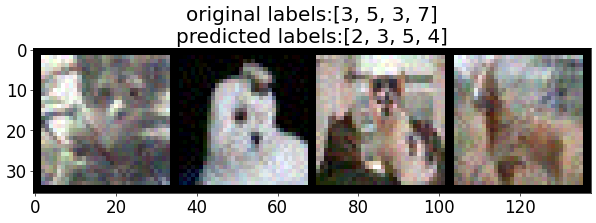

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: dog (5)
Image #1: cat (3)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: cat (3)
Image #1: dog (5)
Image #1: deer (4)


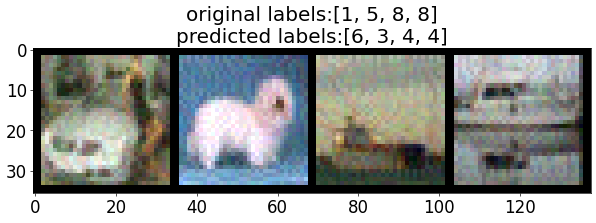

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: dog (5)
Image #1: ship (8)
Image #1: ship (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: cat (3)
Image #1: deer (4)
Image #1: deer (4)
[Step #0] Loss: 1.1130 Accuracy: 0.0000% Time elapsed: 0.8761s (total 64 images)
[Step #10] Loss: 1.1064 Accuracy: 0.0000% Time elapsed: 5.8331s (total 704 images)
[Step #20] Loss: 1.1037 Accuracy: 0.0000% Time elapsed: 10.8326s (total 1344 images)
[Step #30] Loss: 1.1035 Accuracy: 0.0000% Time elapsed: 15.8694s (total 1984 images)
[Step #40] Loss: 1.1056 Accuracy: 0.0000% Time elapsed: 20.9180s (total 2624 images)
[Step #50] Loss: 1.1048 Accuracy: 0.0000% Time elapsed: 25.9474s (total 3264 images)
[Step #60] Loss: 1.1056 Accuracy: 0.0000% Time elapsed: 30.9362s (total 3904 images)
[Step #70] Loss: 1.1065 Accuracy: 0.0000% Time elapsed: 35.8943s (total 4544 images)
[Step #80] Loss: 1.1068 Accuracy: 0.0000% Time elapsed: 40.8272s (total 5184 images)


In [28]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted, perturbation = pgd_attack(model, inputs, labels, False, eps, alpha, iters)  # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

* Black-box attack

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


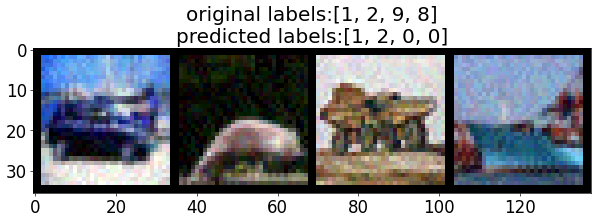

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: bird (2)
Image #1: truck (9)
Image #1: ship (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: bird (2)
Image #1: airplane (0)
Image #1: airplane (0)


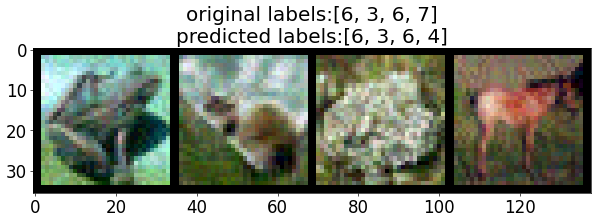

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: cat (3)
Image #1: frog (6)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: cat (3)
Image #1: frog (6)
Image #1: deer (4)
[Step #0] Loss: 0.0241 Accuracy: 68.7500% Time elapsed: 0.8825s (total 64 images)
[Step #10] Loss: 0.0329 Accuracy: 62.3580% Time elapsed: 5.8430s (total 704 images)
[Step #20] Loss: 0.0330 Accuracy: 61.6815% Time elapsed: 10.8252s (total 1344 images)
[Step #30] Loss: 0.0320 Accuracy: 63.3064% Time elapsed: 15.8189s (total 1984 images)
[Step #40] Loss: 0.0319 Accuracy: 63.6433% Time elapsed: 20.8353s (total 2624 images)
[Step #50] Loss: 0.0320 Accuracy: 63.6642% Time elapsed: 25.8391s (total 3264 images)
[Step #60] Loss: 0.0325 Accuracy: 63.3709% Time elapsed: 30.8374s (total 3904 images)
[Step #70] Loss: 0.0329 Accuracy: 63.3583% Time elapsed: 35.8385s (total 4544 images)
[Step #80] Loss: 0.0329 Accuracy: 63.3295% Time elapsed: 40.8405s (total 5184 imag

In [29]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted, perturbation = pgd_attack(model, inputs, labels, False, eps, alpha, iters)  # adversarial attack

    outputs = black_box_model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>MI-FGSM Attack</b>

* White-box attack

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


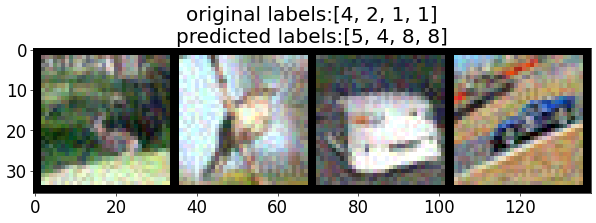

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: bird (2)
Image #1: automobile (1)
Image #1: automobile (1)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: deer (4)
Image #1: ship (8)
Image #1: ship (8)


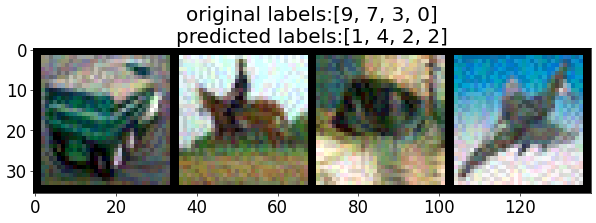

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: horse (7)
Image #1: cat (3)
Image #1: airplane (0)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: deer (4)
Image #1: bird (2)
Image #1: bird (2)
[Step #0] Loss: 1.1839 Accuracy: 0.0000% Time elapsed: 0.9554s (total 64 images)
[Step #10] Loss: 1.1868 Accuracy: 0.0000% Time elapsed: 5.8784s (total 704 images)
[Step #20] Loss: 1.1833 Accuracy: 0.0000% Time elapsed: 10.7975s (total 1344 images)
[Step #30] Loss: 1.1849 Accuracy: 0.0000% Time elapsed: 15.7160s (total 1984 images)
[Step #40] Loss: 1.1831 Accuracy: 0.0000% Time elapsed: 20.6380s (total 2624 images)
[Step #50] Loss: 1.1840 Accuracy: 0.0000% Time elapsed: 25.5607s (total 3264 images)
[Step #60] Loss: 1.1842 Accuracy: 0.0000% Time elapsed: 30.4954s (total 3904 images)
[Step #70] Loss: 1.1845 Accuracy: 0.0000% Time elapsed: 35.4290s (total 4544 images)
[Step #80] Loss: 1.1853 Accuracy: 0.0000% Time elapsed: 40.3608s (total 5184 i

In [30]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted, perturbation = mi_fgsm_attack(model, inputs, labels, False, eps, alpha, iters, decay=1.0)  # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

* Black-box attack

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


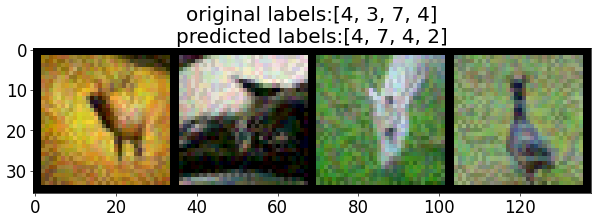

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: cat (3)
Image #1: horse (7)
Image #1: deer (4)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: horse (7)
Image #1: deer (4)
Image #1: bird (2)


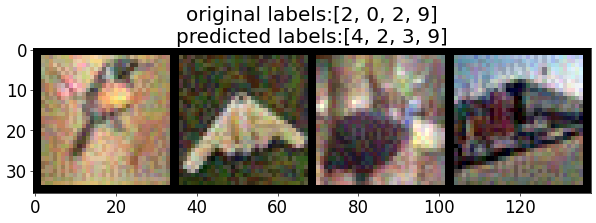

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: airplane (0)
Image #1: bird (2)
Image #1: truck (9)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: bird (2)
Image #1: cat (3)
Image #1: truck (9)
[Step #0] Loss: 0.0692 Accuracy: 42.1875% Time elapsed: 0.8748s (total 64 images)
[Step #10] Loss: 0.0562 Accuracy: 45.8807% Time elapsed: 5.8483s (total 704 images)
[Step #20] Loss: 0.0545 Accuracy: 48.2887% Time elapsed: 10.8243s (total 1344 images)
[Step #30] Loss: 0.0518 Accuracy: 49.6472% Time elapsed: 15.7997s (total 1984 images)
[Step #40] Loss: 0.0508 Accuracy: 50.4192% Time elapsed: 20.7719s (total 2624 images)
[Step #50] Loss: 0.0507 Accuracy: 50.3064% Time elapsed: 25.7451s (total 3264 images)
[Step #60] Loss: 0.0511 Accuracy: 50.2561% Time elapsed: 30.7187s (total 3904 images)
[Step #70] Loss: 0.0507 Accuracy: 49.8900% Time elapsed: 35.6910s (total 4544 images)
[Step #80] Loss: 0.0501 Accuracy: 50.1736% Time elapsed: 40.6741s (total 518

In [31]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted, perturbation = mi_fgsm_attack(model, inputs, labels, False, eps, alpha, iters, decay=1.0)  # adversarial attack

    outputs = black_box_model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))